## Credit Card Fraud Detection using an imbalanced Dataset



#### User Defined Functions

In [2]:
# converts list of dictionary of intances into dictionary of features 
# and returns column oriented dataframe 
def load_data(data):
    parse_data=data[0].keys()
    trans_data={}
    for i in parse_data:
        trans_data[i]=list()
    for row in data:
        for keys,values in row.items():
            if values=='':
                trans_data[keys].append(float("NaN")) #missing datapoints are assigned with 'NaN'
            else:
                trans_data[keys].append(values)
    return pd.DataFrame.from_dict(trans_data)

#for Normalizing 
def normalize(data):
    upper_value = data.max()
    lower_value = data.min()
    x = (data - lower_value)/(upper_value-lower_value)
    return x

#shuffiling and splitting the data
def split_train_test(data, test_ratio):
    np.random.seed(95)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#performance of model on training data
def model_performance_training (model,x,y):
    model.fit(x,y)
    pred=model.predict(x)
    print("Model Training Performance",)
    print("--------------------------")
    print ("Accuracy:",accuracy_score(y,pred))
    print ("precision:", precision_score(y,pred))
    print ("Recall:",recall_score(y,pred))
    print ("F1 Score:",f1_score(y,pred))

#performance on test Data
def model_Evaluation_scores(model,x_test,y_test):
    y_pred=model.predict(x_test)
    print("Model Evaluation Scores")
    print("--------------------------")
    print ("Accuracy:",accuracy_score(y_test,y_pred))
    print ("precision:", precision_score(y_test,y_pred))
    print ("Recall:",recall_score(y_test,y_pred))
    print ("F1 Score:",f1_score(y_test,y_pred))
    

### Question1: Load

 #### Importing Modules

In [3]:
import json
import pandas as pd
import os
import math
import datetime
import autocomplete
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer,StandardScaler 
import warnings
warnings.simplefilter('ignore')

#### importing data

In [4]:
contents = open("transactions.txt", "r").read()  
list_dict = [json.loads(str(item)) for item in contents.strip().split('\n')]
transaction_df=load_data(list_dict)

#### Structure of the data

In [5]:
# structure and Distinct customers
transaction_df.shape,len(set(transaction_df['accountNumber']))

((641914, 29), 5000)


1. Number of records    : **641914**

2. Number of Fields     : **29**

3. Number of Customers  : **5000**



#### Missing Values

In [6]:
# Null Value count
missing=transaction_df.isna().sum()
missing=pd.DataFrame(missing)
missing[missing[0]>0]

,0
acqCountry,3913
merchantCountryCode,624
posEntryMode,3345
posConditionCode,287
transactionType,589
echoBuffer,641914
merchantCity,641914
merchantState,641914
merchantZip,641914
posOnPremises,641914


>There are _5 Attributes with missing Values_ and _6 Empty Attributes_. 

>**Note** :The unique attributes 'accountNumber' and 'customerId' are same. so, I'm removing 'customerID' along with the empty fields to reduce the dimensionality of the dataset

In [7]:
#Removing unnecessary variables 
transaction_df=transaction_df.drop(['customerId','echoBuffer',
                                    'merchantCity','merchantState',
                                    'merchantZip','posOnPremises', 
                                    'recurringAuthInd'],axis=1)

#### Summary Statisticts

In [8]:
transaction_df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,641914.000000,641914.000000,641914.000000,641914.000000
mean,10697.210608,6652.828573,135.162497,4044.382035
std,11460.359133,9227.132275,147.053302,5945.510224
min,250.000000,-1244.930000,0.000000,0.000000
25%,5000.000000,1114.970000,32.320000,502.442500
50%,7500.000000,3578.165000,85.800000,2151.860000
75%,15000.000000,8169.185000,189.030000,5005.890000
max,50000.000000,50000.000000,1825.250000,47496.500000


#### Imputation of missing Values

Since the transaction dataset is imbalanced, to produce an unbiased estimate and retain the relationship between variables I've made few assumptions and utilized unconditional imputation strategies to preserve the missing value patterns.   

1. I believe that _'transactionType'_ attribute plays a crucial role. so, I assumed that the data points for this attribute are missing at Random and they depend on the attribute _'transactionAmount"_. 


2. By assuming that missing values of other attributes might help me find some patterns. I'm retaining them for analysis instead of holding only Complete Cases.

In [9]:
#missing values of transactionType
transaction_df['transactionType'].value_counts(dropna=False)

PURCHASE                608685
ADDRESS_VERIFICATION     16478
REVERSAL                 16162
NaN                        589
Name: transactionType, dtype: int64

In [10]:
# count of missing 'ADDRESS_VERIFICATION' transactions
count=transaction_df[(transaction_df['transactionAmount']==0) & (transaction_df['transactionType'].isna())].shape[0]
print("missing data points for ADDRESSVERIFICAION category :",count)
#count of missing 'REVERSAL TRANSACTIONS'
count1=transaction_df[(transaction_df['transactionAmount']>0) & (transaction_df['transactionType']=='REVERSAL')].shape[0]+transaction_df[(transaction_df['transactionAmount']==0) & (transaction_df['transactionType']=='REVERSAL')].shape[0]
print("total data points for REVERSAl category :",count1)

transaction_df['transactionType'].fillna('PURCHASE',inplace=True)


missing data points for ADDRESSVERIFICAION category : 0
total data points for REVERSAl category : 16162


>1. In my analysis, I found that _'transactionAmount'_  for ADDRESSVERIFICATION category is 0$. so, I verified if there are any missing data points for 
'AddressVerification' category in _'transactionType'_ attribute. which is 0.

>2. I also found the there are few REVERSAL Transactions with transactionAmount=0. from my analysis, none of the data values were missing for REVERSAL transaction in _'transactionType'_ attribute.


>3. From the above assumptions and analysis, I've deduced that all the missing data values belongs to the PURCHASE category for _'transactionType'_ attribute.

#### Exploring Variables

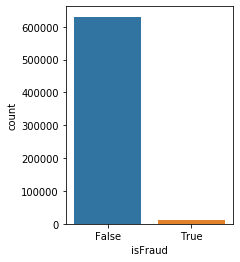

In [11]:
#Bar plot of 'isFraud'
plt.figure(figsize=(3,4))
sns.countplot(x="isFraud", data=transaction_df)
plt.show()

In [12]:
transaction_df[(transaction_df['isFraud']==True)].shape[0]/transaction_df.shape[0]

0.017606719903289225

>It's clearly obvious that the data is imbalanced. we can observe that the proportion of 'False' Class is much greater than the  'True' Class.

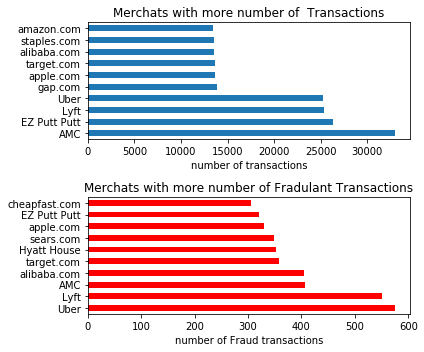

In [13]:
#Merchant Ananysis
transaction_df1=transaction_df.copy()

#removing MerchantID
for i in range(len(transaction_df)):
    if '#' in transaction_df1.loc[i,'merchantName']:
        index=transaction_df1.loc[i,'merchantName'].index('#')
        value=transaction_df1.loc[i,'merchantName'][:index-1]
        transaction_df1.at[i, 'merchantName']=value

#Plotting Merchants 
plt.subplot(2, 1, 1)
transaction_df1['merchantName'].value_counts().head(10).plot(kind='barh',figsize=(6,5))
plt.title('Merchats with more number of  Transactions')
plt.xlabel('number of transactions')


plt.subplot(2,1,2)
transaction_df1[(transaction_df1['isFraud']==True)]['merchantName'].value_counts().head(10).plot(kind='barh',figsize=(6,5),color='red')
plt.title('Merchats with more number of Fradulant Transactions')
plt.xlabel('number of Fraud transactions')

plt.tight_layout()

1. From the above Barchat, we can observe that more than 30000 transactions occurred with AMC followed by Ez Putt Putt, Lyft and Uber.


2. Uber and lyft have a similar number of transactions but fraudulent transactions were occurred with Uber compared to lyft.

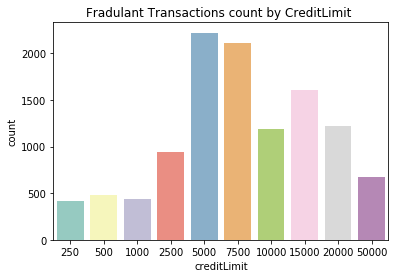

<Figure size 1440x1080 with 0 Axes>

In [14]:
#CreditLimit analysis
fraud=transaction_df.copy()
fraud=fraud[(fraud['isFraud']==1)]
fraud['creditLimit']=fraud['creditLimit'].astype(int)
fraud=fraud.sort_values(by=['creditLimit'])
sns.countplot(x='creditLimit',data=fraud,palette="Set3")
plt.title("Fradulant Transactions count by CreditLimit ")
plt.figure(figsize=(20,15))
plt.show()

### Question2: Plot

1.Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

2.Report any structure you find and any hypotheses you have about that structure.

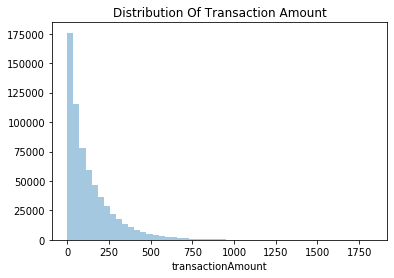

<Figure size 792x432 with 0 Axes>

In [15]:
#plot of transaction Amount
sns.distplot(transaction_df['transactionAmount'],kde=False)
plt.title('Distribution Of Transaction Amount')
plt.figure(figsize=(11,6))
plt.show()

1. From the Above Plot, the distribution of _transactionAmount_ is non-normal and positive skewed. 

2. Here the mean transaction amount is greater than the Median Transaction Amount and the Distribution is right-skewed due to the presence of many outliers.

3. we can Also observe that more 95% of the _transactionAmount_ is below 750$ 

4. since the data is substantially positive skewed with zero values, we use log(x+c) transformation to normalize the variable. 

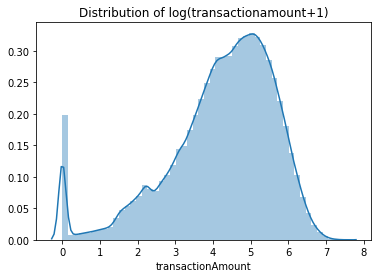

In [16]:
#transformed PLot
trans=np.log1p(transaction_df.transactionAmount)
sns.distplot(trans)
plt.title('Distribution of log(transactionamount+1)')
plt.show()

In [17]:
#Confidence interval for transaction Amount at 95% confidence Levellook with known population parameters

#drawing a sample drom the population
sample=transaction_df['transactionAmount'].sample(n=25, random_state=9896) 
sample_mean=sample.mean()
std=transaction_df['transactionAmount'].std()
n=25
SE=std/math.sqrt(n)
#Estimating Confidence Interval
confidence_interval=[]
confidence_interval.append(sample_mean-1.96*SE) 
confidence_interval.append(sample_mean+1.96*SE)
confidence_interval

[55.589905595680015, 170.87969440431996]

For any given Transaction the transaction amount will be in the range [55.58,170.87] at 95% confidence level 

### Question3: Data Wrangling - Duplicate Transactions

**Can you programmatically identify reversed and multi-swipe transactions?**
>yes, by using _transactionType_ we can identify reversed Transactions and by using _accountNumber_ , _transactionAmount_ ,_transactionDateTime_ and _merchantName_ we can identify multi-swipe transactions. 

**What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions?**


##### REVERSED TRANSACTIONS

In [18]:
# total Number of Reversed Transactions
transaction_df[(transaction_df['transactionType']=='REVERSAL')].shape[0]

16162

In [19]:
#total number of Reversed transactions with zero transaction amount
transaction_df[(transaction_df['transactionType']=='REVERSAL') & (transaction_df['transactionAmount']==0)].shape[0]

501

In [20]:
#total dollar amount for reversed transaction
transaction_df[(transaction_df['transactionType']=='REVERSAL')]['transactionAmount'].sum().round(4)

2242915.1

In [21]:
#Mean reversed transaction amount including zero
transaction_df[(transaction_df['transactionType']=='REVERSAL')]['transactionAmount'].mean()

138.77707585694796

In [22]:
#Mean of reversed transaction amount when transaction amount is more than zero
transaction_df[(transaction_df['transactionType']=='REVERSAL')& (transaction_df['transactionAmount']>0)]['transactionAmount'].mean()

143.21659536428027

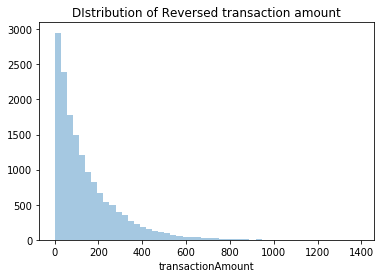

In [23]:
sns.distplot(transaction_df[(transaction_df['transactionType']=='REVERSAL')&(transaction_df['transactionAmount']>0)]['transactionAmount'],kde=False)
plt.title("DIstribution of Reversed transaction amount")
plt.show()

##### MULTIPLE-SWIPE TRANSACTIONS

**Assumption** : For identifying multiple-swipe transactions, I'm considering the multi-swipes that took place in a time span of below 3 minutes. In addition, I'm dropping the instances where transactionAmount=0 and transactionType='REVERSAL' to identify multiple-swipes where the customer has been charged before the transaction got reversed.

In [24]:
multiple_swipe=transaction_df[['accountNumber','transactionAmount','merchantName','transactionType','transactionDateTime']]
multiple_swipe.reset_index(level=0, inplace=True)

In [25]:
#converting into TimeStamp
for i in range(len(multiple_swipe)):
    value=datetime.datetime.strptime(multiple_swipe.loc[i,'transactionDateTime'],'%Y-%m-%dT%H:%M:%S')
    multiple_swipe.at[i, 'transactionDateTime']=value

In [26]:
# multi-swipe transactions including reversed 
multi_swipe_index=[]
multi_swipe_count=0
i=1
while (i!=len(multiple_swipe)):
    if i==len(multiple_swipe):
        break
    if (multiple_swipe.loc[i,'accountNumber']==multiple_swipe.loc[i-1,'accountNumber']) and(multiple_swipe.loc[i,'transactionAmount']==multiple_swipe.loc[i-1,'transactionAmount']) and (multiple_swipe.loc[i,'merchantName']==multiple_swipe.loc[i-1,'merchantName']) and (multiple_swipe.loc[i,'transactionDateTime']-multiple_swipe.loc[i-1,'transactionDateTime']).seconds<180:
        multi_swipe_count+=1
        multi_swipe_index.append(multiple_swipe.loc[i,'index'])
        i=i+1
    else:
        i+=1
multi_swipe=multiple_swipe.loc[multi_swipe_index]

In [27]:
#filtering out reversed transactions
multi_swipe=multi_swipe[(multi_swipe['transactionAmount']>0) & (multi_swipe['transactionType']!='REVERSAL')]


In [28]:
multi_swipe.head(13)[6:]

,index,accountNumber,transactionAmount,merchantName,transactionType,transactionDateTime
997,997,885773130,50.93,Franks Pub #87366,PURCHASE,2016-10-18 20:19:16
1071,1071,799731758,124.77,Dinosaur Sandwitch Bar #960325,PURCHASE,2016-09-01 08:10:36
1230,1230,784469543,271.60,Hyatt House #461673,PURCHASE,2016-05-11 05:43:42
1290,1290,784469543,401.06,Hilton Hotels #89655,PURCHASE,2016-07-07 16:39:42
1312,1312,784469543,184.44,alibaba.com,PURCHASE,2016-07-24 12:32:36
1439,1439,784469543,398.04,Uber,PURCHASE,2016-10-31 18:12:41
1440,1440,784469543,398.04,Uber,PURCHASE,2016-10-31 18:15:27


In [29]:
#total multi-swipes excluding the initial normal transaction
multi_swipe.shape[0]

5989

In [30]:
#total dollaramount of multi-swipes 
multi_swipe.transactionAmount.sum().round(2)

885149.17

In [31]:
#mean dollaramount of multi-swipes 
mean=multi_swipe.transactionAmount.mean()
round(mean,2)

147.8

**Did you find anything interesting about either kind of transaction?**

1.Total Number of Reversed Transactions: 16162

1. Total dollar amount of Reversed Transactions: 2242915.1

1. Mean dollar amount for reversed transaction(including zero trasaction amount): 138.78
1. Mean dollar amount for reversed transaction(Excluding zero trasaction amount): 143.22


1.Total Number of Multi-swipes : 5989
1. Total dollar amount of Multi-swipes : 885149.17
1. Mean dollar amount for multi-swipe Transactions: 147.8


### Question4: Model

In [32]:
#importing required Modules and Algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler, MinMaxScaler, FunctionTransformer,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE

#### Data-PreProcessing

In [33]:
#dropping few more unnecessry columns for modeling 
#to avoid the model from memorizaton dropping account numbers
transaction_df1=transaction_df1.drop(['merchantName','accountNumber','transactionDateTime','merchantCategoryCode','cardLast4Digits','accountOpenDate','dateOfLastAddressChange','cardCVV','enteredCVV','currentExpDate','expirationDateKeyInMatch'],axis=1)


In [34]:
#Complete Case Analysis
transaction_df_CCA=transaction_df1.dropna(inplace=False)
transaction_df_CCA['isFraud']=transaction_df_CCA.isFraud.astype(np.uint8)

#Removing Outliers
transaction_df_CCA=transaction_df_CCA[(transaction_df_CCA.availableMoney>0)]


I found out that there are many outliers such as negative values for availableMoney attribute. so, I have removed the outliers to transform the positive skewed attribute using log transformation.

In [35]:
#shuffeled full-training set and testing set
train,test = split_train_test(transaction_df_CCA,0.2)
y_train=train['isFraud']
y_test=test['isFraud']
x_train_full=train.drop('isFraud',axis=1)
x_test=test.drop('isFraud',axis=1)
numerical=['availableMoney','transactionAmount','currentBalance']

**Note:** I have used the following pipeline for transforming numerical inputs and to encode categorical inputs with respective encoders. 
1. transactionAmount,CurrentBalance, available money - log transformation
2. Transactiontype has only three categories. so, I have used onehotencoder
3. Creditlimit can be ordered so I've used ordinalEncoder.
4. The rest of the attributes were labeled randomly since they come under nominal attributes. 

In [36]:
#pipeline transformation
num_pipeline=Pipeline([
    ('transform',FunctionTransformer(np.log1p))
])
cred_lim_order= [[250,500,1000,2500,5000,7500,10000,15000,20000,50000]]
country_order=[['US','MEX','CAN','PR']]
one_hot=['transactionType']
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical),
    ("oneHot", OneHotEncoder(), one_hot),
    ('ordinal',OrdinalEncoder(categories=cred_lim_order),['creditLimit']),
    ('label_enc_acqCountry ',OrdinalEncoder(categories=country_order),['acqCountry']),
    ('label_enc_mercCountry',OrdinalEncoder(categories=country_order),['merchantCountryCode']),
    ('label_posentry',OrdinalEncoder(),['posEntryMode']),
    ('label_posCondition',OrdinalEncoder(),['posConditionCode']),
    ('label_cardpres',OrdinalEncoder(),['cardPresent'])
    ])
x_train_full_trans=full_pipeline.fit_transform(x_train_full)
x_test_trans=full_pipeline.transform(x_test)

**NOTE**: With the transformed dataset I've trained a few models using dimensionality reduction techniques such as PCA to reduce the dimensions while preserving the variance, but none of them were able to classify the underrepresented labels due to imbalanced proportions of the target class. so, I preferred only 3 numerical attributes that are highly co-related and few models did a good job in identifying the underrepresented targets.

In [37]:
#SGD Classifier with nuerical Inputs
x_train=train[numerical]
sgd_clf = SGDClassifier(random_state=56)
model_performance_training(sgd_clf,x_train,y_train)

Model Training Performance
--------------------------
Accuracy: 0.9647797323710721
precision: 0.03182006633499171
Recall: 0.03500969323754134
F1 Score: 0.03333876309931042


In [38]:
#Logistic regression with Numerical Inputs
x_train=train[numerical]
log_reg=LogisticRegression(solver='liblinear')
model_performance_training(log_reg,x_train,y_train)

Model Training Performance
--------------------------
Accuracy: 0.9826500170136663
precision: 0.3333333333333333
Recall: 0.00011403808872163302
F1 Score: 0.00022799817601459188


1. The Accuracy score of Logistic Regression is greater than SGDClassifier but SGDClassifier did a better job compared to Logistic Regression in terms of F1score. It's quite obvious that overrepresented classed have more weight and are correctly classified. but our aim is to capture as many true positives as possible by reducing False positives. so, Accuracy is not a good performance metric to evaluate the model for this particular dataset.


2. SGDclassifier was able to capture 3.5% of true positives and it's only 3.1% precise. but still, this is not a quite appreciable model since the model is Underfitting the test set.

In [39]:
#Random Forest
x_train=train[numerical]
y_train=train['isFraud']
rf=RandomForestClassifier(random_state=70)

#trainingPerformance
model_performance_training(rf,x_train,y_train)

Model Training Performance
--------------------------
Accuracy: 0.9998911916688429
precision: 0.9997705895847672
Recall: 0.9939559812977534
F1 Score: 0.996854806427632


In [40]:
#Evaluating Model
model_Evaluation_scores(rf,x_test[numerical],y_test)

Model Evaluation Scores
--------------------------
Accuracy: 0.9827725373512282
precision: 0.06741573033707865
Recall: 0.002857142857142857
F1 Score: 0.005481955230698949


RandomForest did a better job on training data byoutperforming Logistic and SGDClassifier but overfitting the test data. so, toovercome this issue, I'have tried resampling techniques such as OverSamplingand Under Sampling but nothing improved the model's performance. so, I'm usingSMOTE(Synthetic Minority Oversampling Technique) that uses nearest under-represented samples to generate duplicate instances of underrepresentedsamples. 


### Synthetic Minority Oversampling Technique

In [41]:
#smote+Logistic
model=SGDClassifier(random_state=56)
smote_pipeline = make_pipeline(SMOTE(random_state=12), model)
smote_pipeline.fit(x_train[numerical], y_train)

model_Evaluation_scores(smote_pipeline,x_test[numerical],y_test)

Model Evaluation Scores
--------------------------
Accuracy: 0.5604187769055458
precision: 0.023686883989520024
Recall: 0.6328571428571429
F1 Score: 0.04566461078564434


>when it comes to F1 score the logistic Regression model with SMOTE did 100 times better job on test data where as the previous logistic regression with out sampling technique was underfitting the training data.

In [42]:
#Smote+Random 
pipe = make_pipeline(SMOTE(k_neighbors=6),RandomForestClassifier(random_state=70))

# # scores=cross_val_score(pipe,x_train,y_train,cv=5,scoring="f1")
# # print("mean_Crossvalidation_scores",scores.mean())

pipe.fit(x_train[numerical],y_train)


model_Evaluation_scores(pipe,x_test[numerical],y_test)

Model Evaluation Scores
--------------------------
Accuracy: 0.7827614585971132
precision: 0.02245328511151296
Recall: 0.2838095238095238
F1 Score: 0.0416142996788158


>Same goes for Randomforest with SMOTE, the model performed almost 10 times better job than Randomforest with out sampling. 

I wanted to build an efficient classification model that could find patterns from the entire dataset including categorical attributes. Initially, I have used a soft voting classifier with Logistic regression, SVM and Decision tree as predictors. It turns out that the classifiers were so weak to identify patterns even with SMOTE.so, I preferred the following classifiers that can handle more features in identifying the patterns from the transformed dataset.

1. SGDClassifier.

2. RandomForestClassifier.

3. Extra Tree.

I have preferred these classifiers because these models are stochastic in nature and can minimize the cost function efficiently. In fact, ExtraTree is more random compared to the other two models because it uses a random threshold in the first split. whereas Randomforest uses a feature and threshold pair for splitting.

In addition, to find the hyperparameters for the algorithm I have used GridSearchCV to hyper tune the algorithm and captured the best estimator that performed better on validation data considering f1 score.

After capturing the best estimator, I have designed a pipeline that will first sample the instances using SMOTE and fits the sampled dataset to the best estimator that was captured earlier.

In [43]:
#SMOTE+SGDTuned 
param_grid = [
    {'loss':['log','hinge'],
    'eta0': [0.01,0.03,0.2],
     'penalty':["l2",'l1','elasticnet'],
     'validation_fraction': [0.2]}
    ]
SGD = SGDClassifier()

#Uncomment the below 2 lines before running the entire file

#grid_searchSGD = GridSearchCV(SGD, param_grid, cv=3,scoring='f1')
#grid_searchSGD.fit(x_train_full_trans,y_train)

pipe_sgd = make_pipeline(SMOTE(),grid_searchSGD.best_estimator_)
pipe_sgd.fit(x_train_full_trans,y_train)
model_Evaluation_scores(pipe_sgd,x_test_trans,y_test)


Model Evaluation Scores
--------------------------
Accuracy: 0.6000253228665485
precision: 0.028442938909005958
Recall: 0.6957142857142857
F1 Score: 0.05465155425878128


In [46]:
#SMOTE + RandomForest Tuned
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [60,100],
     'max_features': [2,3,4],
    'max_depth':[4,10]},
    ]
rc = RandomForestClassifier()

#Uncomment the below 2 lines before running the entire file

#grid_search = GridSearchCV(rc, param_grid, cv=3,scoring='f1')
#grid_search.fit(x_train_full_trans,y_train)


pipe_rf = make_pipeline(SMOTE(),grid_search.best_estimator_)
pipe_rf.fit(x_train_full_trans,y_train)

model_Evaluation_scores(pipe_rf,x_test_trans,y_test)

Model Evaluation Scores
--------------------------
Accuracy: 0.6595973664218789
precision: 0.032388571428571426
Recall: 0.6747619047619048
F1 Score: 0.061810250817884396


In [47]:
#SMOTE + Tunened Extra Tree
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [8,15,20],
     'max_features': [2,3,4],
    'max_depth':[5,10]},
    ]
ET = ExtraTreesClassifier()

#Uncomment the below 2 lines before running the entire file

#grid_searchET = GridSearchCV(rc, param_grid, cv=3,scoring='f1')
#grid_searchET.fit(x_train_full_trans,y_train)


pipe_et = make_pipeline(SMOTE(),grid_searchET.best_estimator_)
pipe_et.fit(x_train_full_trans,y_train)

model_Evaluation_scores(pipe_et,x_test_trans,y_test)

Model Evaluation Scores
--------------------------
Accuracy: 0.6969327677893138
precision: 0.03405931417979611
Recall: 0.63
F1 Score: 0.06462485345838218


Finding the best parameters by hyper tuning and using those parameters along with SMOTE actually helped the versatile models to find the patters in a better way. 

1. SGDClassifier's recall was almost 70% and only 2.8% precision meaning the model is able to capture 70% of the true positives and only 2.8% were accurate, this leads to reduced f1 score. There is always a trade-off between precision and recall.


2. Random forest was slightly better with 3.2% precision and 6.1% F1score.


3. compared to the other two models, Extra tree's random nature helped the algorithm to achieve 3.5% precision and 6.4% f1 Score but reduced Recall 63%. 

it's quite difficult to identify which model performed better. since we are giving more importance to identifying true positives I want to consider Extratree as a final model. Before considering, we can actually relay on another performance metric to verify the performance of the three models i.e receiver operating characteristic curve and area under it.

#### ROC AND AUC

In [48]:
#SGD
y_scores_sgd=cross_val_predict(pipe_sgd,x_train_full_trans,y_train,method='decision_function')
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

#RANDOM
y_probas = cross_val_predict(pipe_rf,x_train_full_trans,y_train,method="predict_proba")
y_scores_rf = y_probas[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

#Extra_tree
y_probas = cross_val_predict(pipe_et,x_train_full_trans,y_train,method="predict_proba")
y_scores_et = y_probas[:, 1]
fpr_et, tpr_et, thresholds_et = roc_curve(y_train, y_scores_et)

Area Under ROC
---------------
SGD Classifier: 0.691
Random Forest : 0.711
Extra Tree    : 0.722


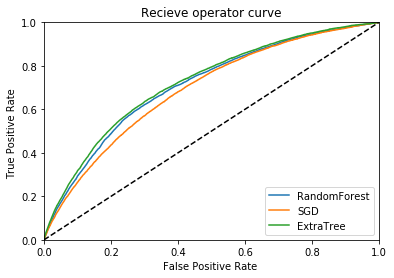

<Figure size 1440x1080 with 0 Axes>

In [49]:
#PLOTTING ROC CURVE
plt.plot(fpr_rf,tpr_rf,label="RandomForest")
plt.plot(fpr_sgd,tpr_sgd,label="SGD")
plt.plot(fpr_et,tpr_et,label="ExtraTree")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate ') 
plt.ylabel('True Positive Rate ')
plt.legend(loc='lower right')
plt.title('Recieve operator curve')
plt.figure(figsize=(20,15))
print('Area Under ROC')
print('---------------')
print('SGD Classifier:',roc_auc_score(y_train, y_scores_sgd).round(3))
print('Random Forest :',roc_auc_score(y_train, y_scores_rf).round(3))
print('Extra Tree    :',roc_auc_score(y_train, y_scores_et).round(3))
plt.show()

**CONCLUSION :** 
From the Above ROC curves and evaluation metrics, it's quite obvious that ExtraTree is a better model compared to SGDClassifier and RandomForest with Area 0.72. so, I want to Consider Extratree as my final model.

To drive deeper into tackling the imbalanced datasets, we could actually find the apportion ratio of sampling the under-represented targets by hyper tuning the SMOTE technique with Keras tuner and build a neural network for classification by using appropriate evaluation metrics. unfortunately, the F1 score Metrics was removed by developers in keras2.0. In the future, I would like to work on solving similar problems by using sophisticated methodologies.

**REFERENCES** :

1. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by  Geron Aurelien

2. Dealing with Imbalanced Data (https://towardsdatascience.com/)

3. Stack-Over flow.